In [1]:
! ls

README.md                datasets.py              example.py
__pycache__              download_cornell.sh      seq2seq-lang-model.ipynb
data                     download_opensubs.sh


In [3]:
! cat download_cornell.sh

#!/bin/bash

mkdir -p data/cornell
cd data/cornell
wget https://github.com/Conchylicultor/DeepQA/raw/master/data/cornell/movie_conversations.txt
wget https://github.com/Conchylicultor/DeepQA/raw/master/data/cornell/movie_lines.txt


In [4]:
! sh download_cornell.sh

--2019-06-22 18:13:55--  https://github.com/Conchylicultor/DeepQA/raw/master/data/cornell/movie_conversations.txt
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Conchylicultor/DeepQA/master/data/cornell/movie_conversations.txt [following]
--2019-06-22 18:13:55--  https://raw.githubusercontent.com/Conchylicultor/DeepQA/master/data/cornell/movie_conversations.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6760930 (6.4M) [text/plain]
Saving to: ‘movie_conversations.txt’

movie_conversations 100%[===================>]   6.45M  1.87MB/s    in 3.4s    

2019-06-22 18:13:59 (1.87 MB/s) - ‘movie_conver

In [75]:
! sh download_opensubs.sh

--2019-06-23 16:38:15--  http://opus.lingfil.uu.se/download.php?f=OpenSubtitles/en.tar.gz
Resolving opus.lingfil.uu.se (opus.lingfil.uu.se)... 130.238.78.148
Connecting to opus.lingfil.uu.se (opus.lingfil.uu.se)|130.238.78.148|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://opus.nlpl.eu/download.php?f=OpenSubtitles/en.tar.gz [following]
--2019-06-23 16:38:15--  http://opus.nlpl.eu/download.php?f=OpenSubtitles/en.tar.gz
Resolving opus.nlpl.eu (opus.nlpl.eu)... 193.166.25.9
Connecting to opus.nlpl.eu (opus.nlpl.eu)|193.166.25.9|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://object.pouta.csc.fi/OPUS-OpenSubtitles/v1/xml/en.zip [following]
--2019-06-23 16:38:15--  https://object.pouta.csc.fi/OPUS-OpenSubtitles/v1/xml/en.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.0, 86.50.254.1
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.0|:443... connected.
HTTP request se

In [82]:
! ls data/opensubs/

INFO          LICENSE       OpenSubtitles README


## Datasets 

In [2]:
import datasets
import argparse
import os

In [12]:
dataset_path = 'data/cornell'
max_sentence_length = 10

In [13]:
data = datasets.readCornellData(dataset_path, max_len=max_sentence_length)

100%|██████████| 83097/83097 [00:05<00:00, 14642.59it/s]


In [83]:
data2 = datasets.readOpensubsData('data/opensubs', max_len=max_sentence_length)

OpenSubtitles data files: 100%|██████████| 4637/4637 [00:00<00:00, 1613488.27it/s]
0it [00:00, ?it/s]

Loading OpenSubtitles conversations in data/opensubs.


In [32]:
data = [(preprocess_sentence(a), preprocess_sentence(b)) for (a,b) in create_dataset(num_examples)]

100%|██████████| 83097/83097 [00:08<00:00, 9914.08it/s] 


In [80]:
len(data), len(data2)

(5256, 0)

In [81]:
data2[:10]

[]

## Data preprocessing 

In [72]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
#     w = unicode_to_ascii(w.lower().strip())
    w = w.lower().strip()
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [15]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,

def create_index(phrases):   
    
    word2idx = {}
    idx2word = {}
    vocab = set()
    
    for phrase in phrases:
        vocab.update(phrase.split(' '))
    
    vocab = sorted(vocab)
    
    word2idx['<pad>'] = 0
    for index, word in enumerate(vocab):
        word2idx[word] = index + 1
    
    for word, index in word2idx.items():
        idx2word[index] = word
        
    return word2idx, idx2word, vocab

## Tensorflow imports

In [7]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf

tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

1.13.1


In [28]:
def create_dataset(num_examples, dataset_name = 'cornell', max_sentence_length= 10):
    dataset_path = 'data/{}'.format(dataset_name)

    if dataset_name == "cornell":
        data = datasets.readCornellData(dataset_path, max_len=max_sentence_length)
    elif dataset_name == "opensubs":
        data = datasets.readOpensubsData(dataset_path, max_len=max_sentence_length)
    else:
        raise ValueError("Unrecognized dataset: {!r}".format(dataset_name))
    
    return data

def max_length(tensor):
    return max(len(t) for t in tensor)

# def preprocess_sentence(s):
#     return '<start> ' + s + ' <end>'


def load_dataset(num_examples):
    # creating cleaned input, output pairs
    pairs = [(preprocess_sentence(a), preprocess_sentence(b)) for (a,b) in create_dataset(num_examples)]

    # index language using the class defined above    
    word2idx, idx2word, vocab = create_index([p for ps in pairs for p in ps])
    # Vectorize the input and target languages
    
    # question sentences
    input_tensor = [[word2idx[w] for w in qs.split(' ')] for qs, a in pairs]
    
    # answer sentences
    target_tensor = [[word2idx[w] for w in a.split(' ')] for q, a in pairs]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, (word2idx, idx2word, vocab), max_length_inp, max_length_tar

## Prep training data

In [29]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, dict_index, max_length_inp, max_length_targ = load_dataset(num_examples, )

100%|██████████| 83097/83097 [00:05<00:00, 14890.06it/s]


In [30]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(4204, 4204, 1052, 1052)

### Create TF dataset

In [37]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_size = len(dict_index[0])
vocab_tar_size = vocab_size

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

## NN Model

In [39]:
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [40]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [41]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [ ]:

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

# Training

### setup 

In [42]:
encoder = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_size, embedding_dim, units, BATCH_SIZE)
optimizer = tf.train.AdamOptimizer()

In [54]:
dict_index[0]['<start>']

36

In [57]:
word2idx = dict_index[0]

In [55]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training explained

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [60]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.4769
Epoch 1 Loss 1.5263
Time taken for 1 epoch 221.04495096206665 sec

Epoch 2 Batch 0 Loss 1.3829
Epoch 2 Loss 1.4485
Time taken for 1 epoch 211.28798985481262 sec

Epoch 3 Batch 0 Loss 1.5323
Epoch 3 Loss 1.3965
Time taken for 1 epoch 211.8134160041809 sec

Epoch 4 Batch 0 Loss 1.2901
Epoch 4 Loss 1.3429
Time taken for 1 epoch 218.80016374588013 sec

Epoch 5 Batch 0 Loss 1.2519
Epoch 5 Loss 1.2952
Time taken for 1 epoch 227.82110285758972 sec



In [84]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.3679
Epoch 1 Loss 1.2502
Time taken for 1 epoch 177.2892951965332 sec

Epoch 2 Batch 0 Loss 1.1577
Epoch 2 Loss 1.2095
Time taken for 1 epoch 194.33765125274658 sec

Epoch 3 Batch 0 Loss 1.2058
Epoch 3 Loss 1.1729
Time taken for 1 epoch 168.82328701019287 sec

Epoch 4 Batch 0 Loss 1.1595
Epoch 4 Loss 1.1229
Time taken for 1 epoch 178.12910199165344 sec

Epoch 5 Batch 0 Loss 1.0668
Epoch 5 Loss 1.0761
Time taken for 1 epoch 181.23971509933472 sec

Epoch 6 Batch 0 Loss 1.0227
Epoch 6 Loss 1.0211
Time taken for 1 epoch 168.97692489624023 sec

Epoch 7 Batch 0 Loss 0.9472
Epoch 7 Loss 0.9687
Time taken for 1 epoch 170.32097911834717 sec

Epoch 8 Batch 0 Loss 0.8261
Epoch 8 Loss 0.9197
Time taken for 1 epoch 165.8781189918518 sec

Epoch 9 Batch 0 Loss 0.8883
Epoch 9 Loss 0.8649
Time taken for 1 epoch 169.77385807037354 sec

Epoch 10 Batch 0 Loss 0.7643
Epoch 10 Loss 0.8175
Time taken for 1 epoch 198.46596884727478 sec

Epoch 11 Batch 0 Loss 0.7243
Epoch 11 Loss 0.7721


## Prediction 
* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [61]:
def evaluate(sentence, encoder, decoder, dictionary_index,  max_length):
    word2idx = dictionary_index[0]
    idx2word = dictionary_index[1]
    attention_plot = np.zeros((max_length, max_length))
    
    sentence = preprocess_sentence(sentence)

    inputs = [word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += idx2word[predicted_id] + ' '

        if idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [62]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [63]:
def answer(sentence, encoder, decoder, dictionary_index, max_length):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, dictionary_index, max_length)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Testing 

In [85]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hello <end>
Predicted translation: hello <end> 


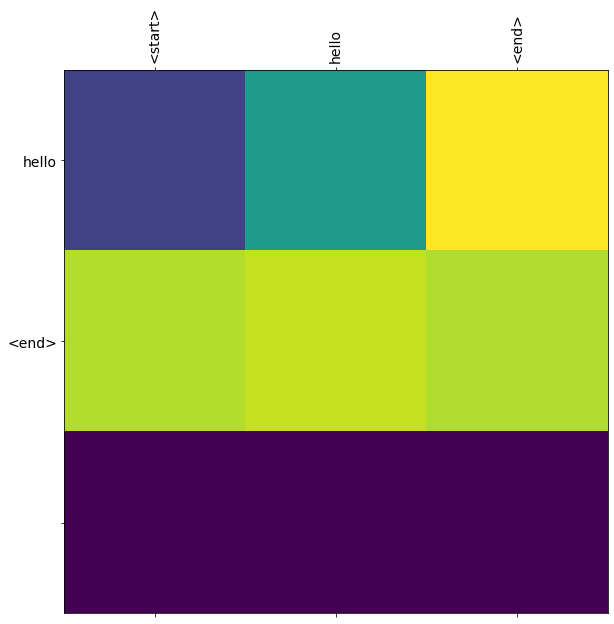

In [94]:
answer('Hello', encoder, decoder, dict_index, max_length_targ)

Input: <start> how are you doing <end>
Predicted translation: im bored <end> 


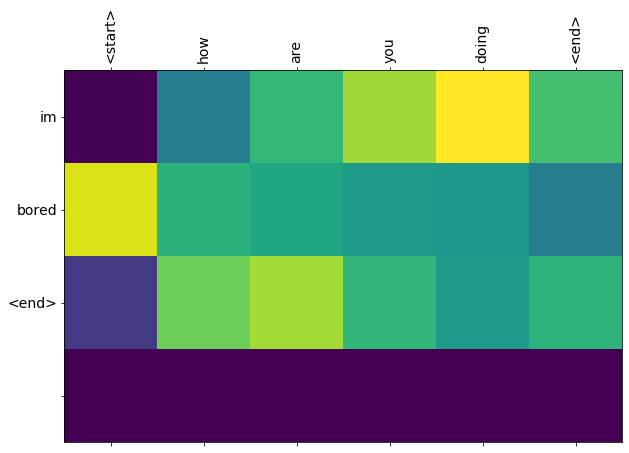

In [93]:
answer('How are you doing', encoder, decoder, dict_index, max_length_targ)

Input: <start> what do you like <end>
Predicted translation: what <end> 


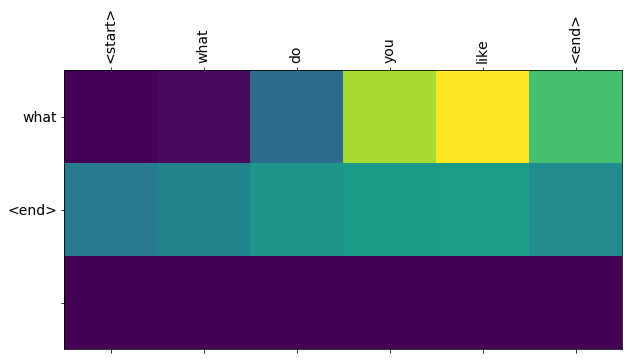

In [92]:
answer('what do you like', encoder, decoder, dict_index, max_length_targ)

## Scratchpad

In [64]:
max_length_inp, max_length_targ 

(5, 6)

In [49]:
target_tensor_train[0], 1 - np.equal(target_tensor_train[0], 0)

(array([  36, 2430, 1597,   35,    0,    0], dtype=int32),
 array([1, 1, 1, 1, 0, 0]))

In [46]:
input_tensor_train[0], target_tensor_train[0]

(array([  36, 1580,   35,    0,    0], dtype=int32),
 array([  36, 2430, 1597,   35,    0,    0], dtype=int32))

In [59]:
q_index = create_index([q for q, a in data])
q_word2idx = q_index[0]
len(q_word2idx)

1861

In [60]:
[[q_word2idx[w] for w in qs.split(' ')] for qs, a in data]

[[1618],
 [1823],
 [1471, 1202],
 [1781],
 [813, 1097],
 [1626],
 [1202],
 [1576, 776, 449],
 [1781],
 [465],
 [449, 1770],
 [1781],
 [1845, 1353, 1521],
 [1784],
 [546],
 [1613, 479],
 [1162],
 [1845, 1622],
 [1427, 811],
 [1162],
 [1629],
 [1162, 1162, 1753],
 [1316],
 [76],
 [76],
 [76],
 [76],
 [723, 749],
 [1612, 648],
 [760, 1745, 811],
 [1358],
 [682],
 [1128],
 [1834],
 [819],
 [713],
 [726, 813, 1035],
 [723],
 [1767, 1425],
 [648, 973],
 [15, 13],
 [1483],
 [348],
 [1779, 1207],
 [105],
 [1684],
 [934, 969],
 [1602, 1035],
 [776, 969, 1845],
 [713],
 [724, 1702],
 [1522],
 [1715, 612],
 [246, 384],
 [1787, 821],
 [1303, 1808],
 [1727],
 [1358],
 [1619, 1406],
 [1405, 1206],
 [1834],
 [449, 1770],
 [1770, 1617],
 [813, 1570],
 [1162],
 [1840],
 [1202],
 [648, 1781],
 [1845, 1202],
 [1845, 1202],
 [588, 811],
 [863, 449, 811],
 [1834],
 [154],
 [1388],
 [1781],
 [1678],
 [1087],
 [67],
 [385],
 [653, 811],
 [1160],
 [590],
 [843],
 [1207],
 [1474],
 [1235],
 [484],
 [500],
 [50

In [27]:
data[:100]

[('there', 'where'),
 ('wow', 'lets go'),
 ('she okay', 'i hope so'),
 ('who', 'joey'),
 ('its more', 'expensive'),
 ('thirtytwo', 'get out'),
 ('okay', 'im fine im'),
 ('sure i do', 'why'),
 ('who', 'dorsey'),
 ('dorsey', 'i hate him'),
 ('do what', 'this'),
 ('who', 'bianca'),
 ('you re so', 'pleasant'),
 ('wholesome', 'unwelcome'),
 ('fallacy', 'the duck'),
 ('the duck', 'hearsay'),
 ('no', 'no what'),
 ('you think', 'oh yeah'),
 ('say it', 'what'),
 ('no', 'no'),
 ('thousands', 'why'),
 ('no no way', 'but its'),
 ('pretty', 'hmmmm'),
 ('alright', 'alright'),
 ('alright', 'alright'),
 ('alright', 'alright'),
 ('alright', 'okay'),
 ('hey honey', 'hey'),
 ('thats good', 'yeah'),
 ('how was it', 'not good'),
 ('really', 'yes'),
 ('hal', 'yes'),
 ('name', 'hammond'),
 ('yeah', 'vodka'),
 ('jack', 'yeah'),
 ('hello', 'hi its me'),
 ('hi its me', 'fuck you'),
 ('hey', 'shut up'),
 ('were saved', 'im fucked'),
 ('good luck', 'of course'),
 ('6 5', 'found it'),
 ('shit', 'what is it'),
 ('c

In [32]:
create_index([a for a,b in data[:100]])

({'<pad>': 0,
  'there': 1,
  'wow': 2,
  'she okay': 3,
  'who': 76,
  'its more': 5,
  'thirtytwo': 6,
  'okay': 67,
  'sure i do': 8,
  'dorsey': 10,
  'do what': 62,
  'you re so': 13,
  'wholesome': 14,
  'fallacy': 15,
  'the duck': 16,
  'no': 65,
  'you think': 18,
  'say it': 19,
  'thousands': 21,
  'no no way': 22,
  'pretty': 23,
  'alright': 27,
  'hey honey': 28,
  'thats good': 29,
  'how was it': 30,
  'really': 58,
  'hal': 32,
  'name': 33,
  'yeah': 73,
  'jack': 35,
  'hello': 50,
  'hi its me': 37,
  'hey': 38,
  'were saved': 39,
  'good luck': 40,
  '6 5': 41,
  'shit': 42,
  'cornelius': 43,
  'which one': 44,
  'apipoussan': 45,
  'uh': 46,
  'like love': 47,
  'tell me': 48,
  'i love you': 49,
  'heywake up': 51,
  'sobering': 52,
  'very funny': 53,
  'but dad': 54,
  'whos jacob': 55,
  'poor woman': 56,
  'vomit': 57,
  'they said': 59,
  'safety on': 60,
  'what then': 63,
  'its stupid': 64,
  'yes': 66,
  'good who': 68,
  'you okay': 99,
  'forget it':